# Analysis of ALMA NGC 253 Data for Density Tracing Species

## 2. Spatial Regridding

#### Goal: To ensure all the images cover the same field of view with the same pixel sizes and locations              ** Computationally intensive especially with data cubes. Err on the side of oversampling --> regrid to match the image with the samllest pixel scale (usually the image with the smallest beam). After this step (or the next Spectral Regridding) save the Python array as a new FITS file

### i. Import Python Packages

In [66]:
#Use this window to import packages you will use later
#When you first start working or import a new package, this cell needs to be run before doing anything else.


import numpy as np                          # I use this for maths and sometimes arrays.
                                            # "np" is just an abbreviation since we call this package so often!
import pylab                                # I use this for arrays and plotting
import matplotlib                           # Another plotting package
import matplotlib.gridspec as gridspec      # If there is a task you use a lot, importing it like this 
                                            # keeps you from having to constantly type "matplotlib.gridspec"
                                            # every time you call that task!
import scipy

import astropy.io.fits as fits              # I use this to import FITS images. 
                                            # Astropy should be included in your conda installation
from astropy.wcs import WCS                 # This one helps us add coordinates to images
from astropy import units as u              # This one helps with unit conversion

import regions

import pyspeckit as psk                     # I use this to do spectral line fitting
                                            # You probably don't have it installed; 
                                            # to install, type 'pip install pyspeckit' in a terminal window
        
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from reproject import reproject_interp      # Reproject is another useful package you should install
from reproject.mosaicking import find_optimal_celestial_wcs 


                                            # Suppress warnings we don't care about:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

                                            # Super important!! 
                                            # This embeds plots in the Jupyter window 
                                            # (instead of showing them as pop-ups)
%matplotlib inline                             

matplotlib.rc('font', family='sans-serif')  # Set plot fonts
matplotlib.rc('text', usetex=True)      
matplotlib.rc('text', usetex=False)        # This is a quick fix if you don't have latex on your computer



### ii. Import Datacube

In [67]:
# Paths of Cropped Datacubes
HCN10_path = '/Users/ashleylieber/MIlls_Research/NGC253_aelieber1/crop_HCN_J1-0.cube.fits'
HCN43_path = '/Users/ashleylieber/MIlls_Research/NGC253_aelieber1/crop_HCN_4-3.cube.fits'
H13CN10_path = '/Users/ashleylieber/MIlls_Research/NGC253_aelieber1/crop_H13CN_1-0.cube.fits'
H13CN43_path = '/Users/ashleylieber/MIlls_Research/NGC253_aelieber1/crop_H13CN_4-3.cube.fits'
HCOp10_path = '/Users/ashleylieber/MIlls_Research/NGC253_aelieber1/crop_HCOp_1-0.cube.fits'
HCOp43_path = '/Users/ashleylieber/MIlls_Research/NGC253_aelieber1/crop_HCOp_4-3.cube.fits'

In [68]:
# Read in Spectral Cubes
HCN10_sc = SpectralCube.read(HCN10_path)
HCN43_sc = SpectralCube.read(HCN43_path)
H13CN10_sc = SpectralCube.read(H13CN10_path)
H13CN43_sc = SpectralCube.read(H13CN43_path)
HCOp10_sc = SpectralCube.read(HCOp10_path)
HCOp43_sc = SpectralCube.read(HCOp43_path)

In [69]:
Cubes = [HCN10_sc, HCN43_sc, H13CN10_sc, H13CN43_sc, HCOp10_sc, HCOp43_sc]

In [70]:
# Quick look at all the cube data + beam info 
# Other datacube attributes can be found here: https://spectral-cube.readthedocs.io/en/latest/api/spectral_cube.SpectralCube.html
'''
for i in Cubes:
    print(i)
    print(i.beam)
    print("Pixels per beam: ", i.pixels_per_beam)
    print()'''

'\nfor i in Cubes:\n    print(i)\n    print(i.beam)\n    print("Pixels per beam: ", i.pixels_per_beam)\n    print()'

In [71]:
# Minimum beam size is 4.86E-05 (same for all 4-3 transition cubes)

In [72]:
### Spatial Reprojection

In [73]:
# Reprojection cube
reprojection_cube = HCN43_sc
reprojection_cube.allow_huge_operations=True
reprojection_moment0 = reprojection_cube.moment(order=0,how='slice')

In [74]:
# test cube
HCN10_sc.allow_huge_operations=True
HCN10_sc_moment0 = HCN10_sc.moment(order=0,how='slice')

In [75]:
HCN10_sc_moment0_reproject, footprint = reproject_interp(HCN10_sc_moment0.hdu, reprojection_moment0.header)

In [76]:
#print(reprojection_cube)

In [77]:
#print(HCN10_sc_moment0_reproject)

In [78]:
ratio_HCN43_HCN10 = reprojection_moment0.hdu.data/HCN10_sc_moment0_reproject

In [91]:
badpix = pylab.where(HCN10_sc_moment0_reproject<20)
badpix2 = pylab.where(reprojection_moment0.hdu.data<-10)
ratio_HCN43_HCN10[badpix] = np.nan
ratio_HCN43_HCN10[badpix2] = np.nan

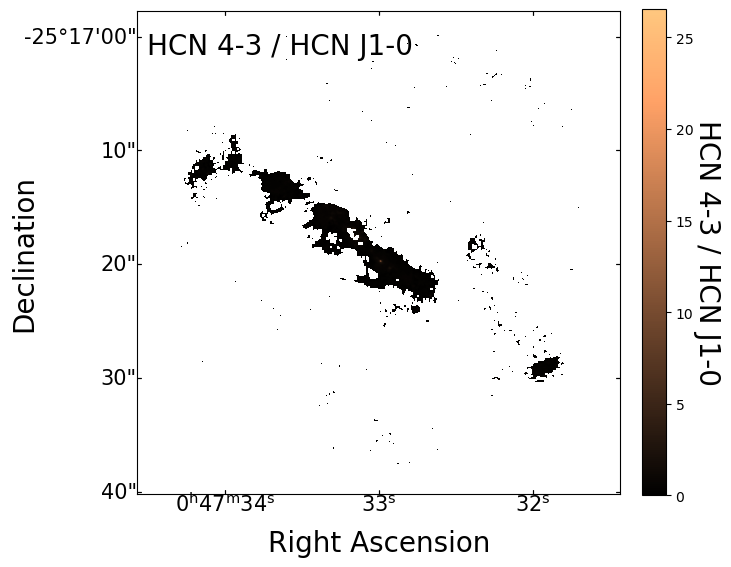

In [97]:
fig1 = pylab.figure(1,figsize=(15,15))
ax1 = pylab.subplot(2,2,1,projection=reprojection_moment0.wcs)
#ax1.set_facecolor('lightblue')
im1 = pylab.imshow(ratio_HCN43_HCN10,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1]
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.046,pad=0.04)                                      
cb.set_label(label='HCN 4-3 / HCN J1-0',fontsize=20,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(text='HCN 4-3 / HCN J1-0',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction");  